In [1]:
# Melakukan impor libraries yang diperlukan untuk membangun model dan prediksi data.
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
import random
import time
import datetime

In [2]:
# Mencatat waktu dimulainya keseluruhan program model dan prediksi data.
global_start_time = time.time()

In [3]:
# Menetapkan nilai seed untuk reproduksi model.
seed = 2021
def set_seed(seed = seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = str(seed)

set_seed()

In [4]:
# Menentukan indeks fold, kode penamaan program, banyak epoch, dan ukuran batch.
fold_index = 0
codename = '1_03_03_{}'.format(fold_index)
epochs = 128
batch_size = 128

In [5]:
# Menyusun data training.
df_train = pd.read_csv('../input/bdc-sd2021-train-tabular-data/train_gray.csv')
fake_train = pd.DataFrame(np.array(df_train).reshape((2305, 128, 128))[:, :, ::-1].reshape((2305, 128*128)))
fake_train.columns = df_train.columns
df_train = pd.concat([df_train, fake_train], ignore_index = True)
del fake_train

# Menyusun data testing.
df_test = pd.read_csv('../input/bdc-sd2021-test-tabular-data/test_gray.csv')

In [6]:
# Melakukan normalisasi pada data training.
scaler = MinMaxScaler(copy = False)
scaler.fit_transform(df_train.T)
df_train

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0.183857,0.139013,0.098655,0.116592,0.121076,0.103139,0.116592,0.094170,0.089686,0.076233,...,0.242152,0.089686,0.103139,0.121076,0.134529,0.156951,0.156951,0.156951,0.174888,0.152466
1,0.857868,0.857868,0.857868,0.857868,0.857868,0.857868,0.842640,0.827411,0.842640,0.827411,...,0.319797,0.294416,0.253807,0.208122,0.147208,0.116751,0.096447,0.065990,0.055838,0.040609
2,0.018182,0.013636,0.013636,0.018182,0.018182,0.018182,0.018182,0.018182,0.013636,0.018182,...,0.568182,0.559091,0.536364,0.518182,0.486364,0.436364,0.368182,0.254545,0.113636,0.045455
3,0.162500,0.162500,0.154167,0.154167,0.166667,0.187500,0.216667,0.254167,0.233333,0.183333,...,0.666667,0.675000,0.745833,0.887500,0.908333,0.900000,0.916667,0.945833,0.966667,0.966667
4,0.893023,0.860465,0.804651,0.879070,0.869767,0.637209,0.479070,0.269767,0.186047,0.186047,...,0.106977,0.032558,0.027907,0.018605,0.004651,0.000000,0.000000,0.004651,0.009302,0.018605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4605,0.090476,0.076190,0.095238,0.114286,0.090476,0.109524,0.076190,0.061905,0.052381,0.076190,...,0.157143,0.114286,0.133333,0.047619,0.061905,0.061905,0.052381,0.042857,0.042857,0.042857
4606,0.356828,0.370044,0.396476,0.409692,0.396476,0.422907,0.471366,0.515419,0.480176,0.436123,...,0.030837,0.035242,0.030837,0.026432,0.022026,0.017621,0.039648,0.026432,0.017621,0.035242
4607,0.306977,0.279070,0.339535,0.330233,0.320930,0.367442,0.367442,0.316279,0.283721,0.339535,...,0.060465,0.074419,0.065116,0.051163,0.051163,0.046512,0.083721,0.065116,0.055814,0.097674
4608,0.145000,0.240000,0.290000,0.295000,0.230000,0.170000,0.185000,0.200000,0.200000,0.230000,...,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.010000,0.010000,0.010000


In [7]:
# Melakukan normalisasi pada data testing.
scaler.fit_transform(df_test.T)
df_test

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0.095238,0.100000,0.100000,0.095238,0.095238,0.100000,0.109524,0.114286,0.119048,0.104762,...,0.347619,0.361905,0.314286,0.400000,0.419048,0.261905,0.233333,0.300000,0.266667,0.257143
1,0.061983,0.061983,0.061983,0.061983,0.061983,0.061983,0.061983,0.061983,0.066116,0.066116,...,0.417355,0.322314,0.285124,0.471074,0.508264,0.475207,0.541322,0.644628,0.611570,0.512397
2,0.531120,0.493776,0.485477,0.427386,0.402490,0.356846,0.340249,0.356846,0.336100,0.340249,...,0.190871,0.112033,0.062241,0.058091,0.074689,0.066390,0.058091,0.053942,0.045643,0.053942
3,0.796703,0.796703,0.791209,0.791209,0.796703,0.818681,0.818681,0.785714,0.763736,0.763736,...,0.961538,0.950549,0.950549,0.945055,0.939560,0.928571,0.923077,0.917582,0.906593,0.879121
4,0.222222,0.232804,0.232804,0.248677,0.253968,0.259259,0.248677,0.243386,0.243386,0.243386,...,0.619048,0.613757,0.608466,0.608466,0.613757,0.592593,0.566138,0.502646,0.470899,0.449735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,0.828571,0.844898,0.804082,0.824490,0.918367,0.963265,0.987755,0.959184,0.873469,0.722449,...,0.857143,0.848980,0.828571,0.832653,0.840816,0.840816,0.816327,0.820408,0.783673,0.767347
986,0.048780,0.065041,0.077236,0.105691,0.117886,0.121951,0.126016,0.069106,0.060976,0.052846,...,0.186992,0.207317,0.223577,0.239837,0.260163,0.284553,0.304878,0.321138,0.337398,0.357724
987,0.056872,0.056872,0.061611,0.061611,0.071090,0.056872,0.037915,0.023697,0.009479,0.018957,...,0.900474,0.890995,0.895735,0.900474,0.895735,0.895735,0.890995,0.890995,0.890995,0.890995
988,0.109244,0.155462,0.168067,0.121849,0.113445,0.088235,0.079832,0.084034,0.079832,0.067227,...,0.525210,0.281513,0.050420,0.033613,0.037815,0.033613,0.033613,0.042017,0.042017,0.042017


In [8]:
# Memunculkan target prediksi.
target_0 = pd.read_csv('../input/bdc-sd2021-data-tambahan/train_target_and_fold.csv')[['usia', 'fold']]
target_1 = pd.concat([target_0 for iteration in range(2)], ignore_index = True)
target_1

,usia,fold
0,27,3
1,27,3
2,27,3
3,24,0
4,24,0
...,...,...
4605,23,4
4606,23,4
4607,27,4
4608,27,4


In [9]:
# Menyusun indeks untuk data training dan melakukan shuffle.
train_index = list(target_1[target_1['fold'] != fold_index].index)
random.seed(seed)
random.shuffle(train_index)

# Menyusun indeks untuk data validasi.
valid_index = list(target_0[target_0['fold'] == fold_index].index)

# Memisahkan data validasi dari data training, serta menginisiasi data testing.
X_train = df_train.iloc[train_index]
X_valid = df_train.iloc[valid_index]
X_test = df_test.copy()

# Mengubah ukuran data agar sesuai dengan input yang diharapkan oleh model.
X_train = X_train.values.reshape(-1, 128, 128, 1)
X_valid = X_valid.values.reshape(-1, 128, 128, 1)
X_test = X_test.values.reshape(-1, 128, 128, 1)

# Memisahkan target validasi dari target training.
y_train = target_1.iloc[train_index, 0]
y_valid = target_0.iloc[valid_index, 0]

# Membuang informasi yang sudah tidak diperlukan lagi.
del df_train, df_test, target_0, target_1, train_index, valid_index

In [10]:
# Membangun model.
def prepare_model():
    model = Sequential([
        Conv2D(filters = 32, kernel_size = (5, 5), padding = 'same',
               activation = 'relu', input_shape = (128, 128, 1)),
        Conv2D(filters = 32, kernel_size = (5, 5), padding = 'same',
               activation = 'relu'),
        MaxPool2D(pool_size = (2, 2)),
        Dropout(0.25),
        Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same',
               activation = 'relu'),
        Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same',
               activation = 'relu'),
        MaxPool2D(pool_size = (2, 2), strides = (2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(512, activation = 'relu'),
        Dropout(0.5),
        Dense(1, activation = 'linear')
    ])
    
    # Mendefinisikan optimizer.
    optimizer = RMSprop(learning_rate = 1e-04,
                        rho = 0.9,
                        epsilon = 1e-08,
                        decay = 0.0)
    
    # Mengkompilasi model.
    model.compile(optimizer = optimizer,
                  loss = 'mean_squared_error',
                  metrics = ['mse'])
    return model

In [11]:
# Menampilkan ringkasan dari model.
model = prepare_model()
model.summary()


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       36992     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0

In [12]:
# Menetapkan batasan untuk berhenti melanjutkan epoch lebih awal.
earlystop = EarlyStopping(patience = 16)

In [13]:
# Menetapkan batasan untuk learning rate.
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_mse', 
                                            patience = 8,
                                            verbose = 1,
                                            factor = 0.5,
                                            mode = 'min',
                                            min_lr = 1e-05)

In [14]:
# Membentuk kelas guna menyimpan output prediksi validasi dan testing untuk setiap epoch.
class Metrics(Callback):
    def __init__(self, valid_data, test_data):
        super().__init__()
        self.valid_data = valid_data
        self.test_data = test_data
    
    def on_epoch_end(self, epoch, logs={}):
        y_valid_pred = self.model.predict(self.valid_data)
        y_test_pred = self.model.predict(self.test_data)
        pd.DataFrame(y_valid_pred).to_csv('valid_preds_{}.csv'.format(epoch), index = False)
        pd.DataFrame(y_test_pred).to_csv('test_preds_{}.csv'.format(epoch), index = False)

In [15]:
# Melakukan fitting model.
model = prepare_model()
history = model.fit(X_train, y_train,
                    epochs = epochs,
                    validation_data = (X_valid, y_valid),
                    verbose = 2,
                    steps_per_epoch = X_train.shape[0] // batch_size,
                    callbacks = [earlystop,
                                 learning_rate_reduction,
                                 Metrics(X_valid,
                                         X_test)])

2021-11-04 02:38:20.091736: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/128
28/28 - 301s - loss: 88.0113 - mse: 88.0113 - val_loss: 164.0339 - val_mse: 164.0339
Epoch 2/128
28/28 - 298s - loss: 59.6926 - mse: 59.6926 - val_loss: 180.5899 - val_mse: 180.5899
Epoch 3/128
28/28 - 300s - loss: 53.4620 - mse: 53.4620 - val_loss: 199.4625 - val_mse: 199.4625
Epoch 4/128
28/28 - 298s - loss: 52.6333 - mse: 52.6333 - val_loss: 143.1874 - val_mse: 143.1874
Epoch 5/128
28/28 - 301s - loss: 50.5599 - mse: 50.5599 - val_loss: 93.6927 - val_mse: 93.6927
Epoch 6/128
28/28 - 300s - loss: 49.8691 - mse: 49.8691 - val_loss: 115.5961 - val_mse: 115.5961
Epoch 7/128
28/28 - 300s - loss: 44.2104 - mse: 44.2104 - val_loss: 136.1218 - val_mse: 136.1218
Epoch 8/128
28/28 - 299s - loss: 43.6400 - mse: 43.6400 - val_loss: 158.9164 - val_mse: 158.9164
Epoch 9/128
28/28 - 301s - loss: 41.3794 - mse: 41.3794 - val_loss: 175.8835 - val_mse: 175.8835
Epoch 10/128
28/28 - 300s - loss: 38.6581 - mse: 38.6581 - val_loss: 135.0212 - val_mse: 135.0212
Epoch 11/128
28/28 - 300s - los

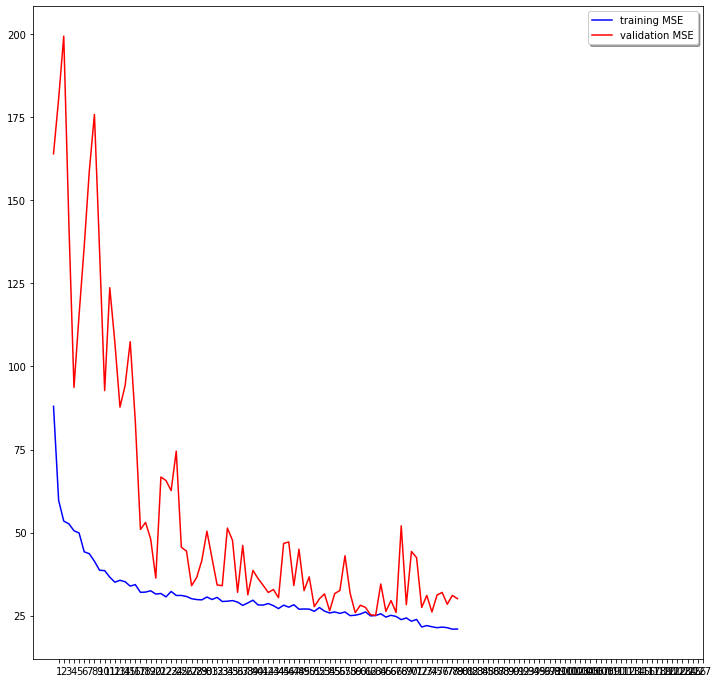

In [16]:
# Melakukan visualisasi nilai MSE pada data training dan testing.
fig, ax = plt.subplots(1, 1, figsize = (12, 12))
ax.plot(history.history['mse'], color='b', label = 'training MSE')
ax.plot(history.history['val_mse'], color='r', label = 'validation MSE')
ax.set_xticks(np.arange(1, epochs, 1))
legend = plt.legend(loc = 'best', shadow = True)
plt.show()

In [17]:
# Menyusun rekam jejak model berdasarkan nilai MSE pada setiap epoch, diurutkan dari yang terbaik.
history_df = pd.DataFrame(history.history).sort_values('val_mse').reset_index()
history_df.rename(columns = {'index': 'epoch'}, inplace = True)
history_df.to_csv('history_{}.csv'.format(codename), index = False)
history_df

,epoch,loss,mse,val_loss,val_mse,lr
0,63,25.022232,25.022232,25.061785,25.061785,0.00010
1,62,24.928068,24.928068,25.260237,25.260237,0.00010
2,59,25.118311,25.118311,25.878941,25.878941,0.00010
3,67,24.736881,24.736881,25.931049,25.931049,0.00010
4,74,21.648537,21.648537,26.087854,26.087854,0.00005
...,...,...,...,...,...,...
75,7,43.640034,43.640034,158.916351,158.916351,0.00010
76,0,88.011307,88.011307,164.033875,164.033875,0.00010
77,8,41.379410,41.379410,175.883530,175.883530,0.00010
78,1,59.692554,59.692554,180.589920,180.589920,0.00010


In [18]:
# Menyimpan nilai prediksi validasi dan testing diurutkan berdasarkan nilai validasi MSE terbaik.
best_valid_preds = pd.DataFrame()
best_test_preds = pd.DataFrame()

for temp_index in list(history_df.iloc[:, 0]):
    temp_df_valid = pd.read_csv('./valid_preds_{}.csv'.format(temp_index))
    temp_df_test = pd.read_csv('./test_preds_{}.csv'.format(temp_index))
    best_valid_preds = pd.concat([best_valid_preds, temp_df_valid], axis = 1, ignore_index = True)
    best_test_preds = pd.concat([best_test_preds, temp_df_test], axis = 1, ignore_index = True)

best_valid_preds.to_csv('valid_preds_{}.csv'.format(codename), index = False)
best_test_preds.to_csv('test_preds_{}.csv'.format(codename), index = False)

In [19]:
# Membuang file yang sudah tidak diperlukan.
for temp_index in list(history_df.iloc[:, 0]):
    os.remove('./valid_preds_{}.csv'.format(temp_index))
    os.remove('./test_preds_{}.csv'.format(temp_index))

In [20]:
# Menampilkan prediksi data validasi diurutkan berdasarkan nilai validasi MSE terbaik.
best_valid_preds

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,27.245853,26.710890,26.608866,26.113436,26.696217,26.618916,26.239746,25.880821,25.622835,25.833782,...,15.649071,15.313534,14.534629,14.544364,14.482416,13.546807,13.572597,12.876493,12.966303,12.270174
1,28.120588,27.616962,27.647259,27.316721,27.840895,27.591928,27.194130,26.863123,26.475899,26.326105,...,17.506025,16.813456,16.235540,16.235003,16.202488,15.064720,15.459200,14.272258,14.612355,13.681609
2,29.082743,28.690365,28.343575,28.778181,29.320677,28.698683,27.533245,28.583935,27.369250,26.679104,...,19.523287,17.378944,17.195196,18.001783,18.259073,16.549475,17.511885,15.503054,16.519203,15.494298
3,23.445684,23.111496,23.296263,22.589773,22.953405,23.696707,23.135670,21.871048,22.565113,22.459991,...,16.902697,15.403715,14.935239,15.520480,15.872209,14.285738,15.320965,13.366455,14.453299,13.487872
4,27.445337,26.829464,26.702295,26.666410,26.852251,25.975048,26.227127,26.125349,25.489832,25.682034,...,13.378175,14.839782,13.665361,12.690401,12.078259,11.976783,11.240675,11.607379,10.683362,10.109705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,22.864532,22.510372,22.413715,22.190845,21.981384,22.268358,21.934890,21.240025,21.520357,21.282774,...,15.686890,15.053628,14.404963,14.525855,14.588635,13.367444,14.067766,12.577886,13.151072,12.260122
457,26.523525,26.107283,25.932827,25.462950,25.949180,25.793528,25.534160,25.240923,25.019669,24.867650,...,13.752008,16.060968,14.915815,13.333466,12.149753,12.731007,11.061421,12.457889,10.540282,10.047003
458,27.075064,26.608131,26.839945,26.253477,26.417019,26.348215,26.355616,25.809650,25.620080,25.781660,...,13.637032,16.144829,14.852604,13.221114,11.954947,12.686099,10.648046,12.467229,10.282281,9.919765
459,25.434778,25.059467,25.130860,24.921340,25.076736,25.452631,24.680130,24.076958,24.140234,24.013746,...,15.989530,16.277943,15.502553,15.032673,14.601959,14.072204,13.507050,13.469079,12.954223,12.330991


In [21]:
# Menampilkan prediksi data testing diurutkan berdasarkan nilai validasi MSE terbaik.
best_test_preds

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,26.341276,25.691742,25.014640,25.330116,25.621372,25.707062,24.778267,24.961327,24.128637,24.004490,...,16.906225,17.458912,16.779394,16.078684,15.290380,15.209287,14.109565,14.614990,13.450629,12.838430
1,26.543330,26.320145,26.657780,25.606665,25.253874,25.806560,26.354412,24.766602,25.346674,25.900688,...,15.955008,16.538462,15.609233,15.058590,14.617160,14.069283,13.719109,13.462878,12.954720,12.297506
2,28.440525,27.798576,27.681690,27.760890,28.678839,28.481117,26.906317,27.369670,26.948978,25.964810,...,17.182358,16.899946,16.396060,16.156311,15.685824,15.140580,14.682556,14.450235,14.040255,13.262417
3,25.208000,25.130466,24.773820,24.319754,23.900051,24.935522,24.667301,23.184685,23.956667,24.270283,...,19.282240,16.535154,16.367298,17.621801,18.249876,16.055933,17.734722,14.890524,16.632502,15.509642
4,30.853954,30.257874,29.849113,29.523243,29.855984,29.531872,29.112587,29.140053,28.735810,28.434952,...,17.396238,15.638443,15.257072,16.011557,16.272495,14.720664,15.631665,13.806170,14.717826,13.787701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,28.660467,28.388393,28.002754,27.637571,27.811092,28.705235,27.706050,26.554157,27.089024,26.949173,...,18.377932,19.500586,18.793505,17.707203,16.292866,16.860853,14.857136,16.323683,14.202232,13.586957
986,28.481554,27.489365,26.374554,27.017464,27.662697,27.183111,25.813091,26.912575,26.028318,25.651543,...,16.926847,16.069025,15.731210,15.845052,15.581803,14.818843,14.856421,14.083302,14.079854,13.220769
987,26.923548,26.663837,26.413208,26.099783,26.262012,26.267675,25.716606,25.450241,25.474659,24.998528,...,16.727867,16.038624,15.438647,15.604496,15.441687,14.520031,14.467535,13.764286,13.736754,13.025645
988,25.371737,24.527613,23.754356,23.729925,23.453085,23.642920,23.924025,22.906239,23.023539,23.510433,...,15.768744,16.742146,16.067040,15.134003,14.100885,14.424764,13.022952,13.973935,12.413817,11.829451


In [22]:
# Menampilkan nilai MSE terbaik pada data validasi.
error = MSE(y_valid, best_valid_preds[0])
print('nilai MSE pada data validasi: ', error)

nilai MSE pada data validasi:  25.06178371624421


In [23]:
# Mencatat waktu berakhirnya keseluruhan program model dan prediksi data.
global_end_time = time.time()

# Menampilkan waktu eksekusi dari keseluruhan program model dan prediksi data.
total_execution_time = datetime.timedelta(seconds = global_end_time - global_start_time)
print("total execution time: %s" % (total_execution_time))

total execution time: 7:23:34.950529
